#  Unsupervised learning addition model

Author: S. Menary [sbmenary@gmail.com]

Date: 5/4/2023  (last update: 5/4/2023)

Overview: Train a `sequence -> sequence` model where the input sequence is a text representation of a simple sum $A \pm B$ for integers $A,B\in\mathbb{Z}\left([-N,~N]\right)$ for some maximum-amplitude $N$, and the output is a text representation of the answer. Since the output is a numerical value, the loss function is a sparse categorical entropy

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import datetime, json, logging, math, os, pickle, random, sys, time

##  Import entire pypi packages
import matplotlib as mpl
import numpy      as np
import tensorflow as tf

##  Import individual modules/objects from python stdlib packages
from pathlib import Path

##  Import individual modules/objects from pypi packages
from tensorflow.keras.callbacks  import Callback, CSVLogger, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers     import Average, Concatenate, Dense, Embedding, Input, Layer, Masking
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam
from matplotlib                  import pyplot as plt

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from mathsformer.data       import add_positions_to_sequences, detokenise_string, detokenise_strings, strings_to_tensor, tokenise_strings
from mathsformer.tf_objects import (create_custom_objects_dict, AttentionBlock, EncoderBlock, FeedForwardBlock,
                                    LayerActivationRecord, LayerWeightsRecord, LoggerCallback, LossRecord,
                                    PositionalEncoding, ReduceSequence, RightSlice, get_nested_sublayers)
from mathsformer.utils      import create_working_directory, fancy_message, initialise_program, log_versions, summarise_dict


### Configuation

Set global configuration variables

In [2]:
##===================##
##   Global config   ##
##===================##


##  Set log levels for logging streams to notebook and to log file in working directory
log_lvl_iostream = logging.INFO
log_lvl_fstream  = logging.DEBUG


##  Create dictionary of config values
##  -  config values to be set here and never changed!
##  -  use nested dictionary as a proxy for namespacing
##  -  e.g. can access data config value like config["data"]["label_prescale"]
global_config = {
    "base_seed"         : -1,
    "working_directory" : "unsupervised_learning_addition_model_[tag]_[date]_[time]",
    "tag"               : "baseline",
    "data" : {
        "max_int"        : 1299,
        "char_tokens"    : ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'],
        "mask_char"      : 'M',
        "seq_start_char" : 'B',
        "seq_end_char"   : 'E',
        "test_split_idx" : 0.05,
        "val_split_idx"  : 0.10,
        "dtype"          : "int32",
    },
    "model" : {
        "load_pretrained_model" : "",
        "ndim_model"            : 32,
        "ndim_embedding"        : 16,
        "num_freqs"             : 8,
        "min_period"            : 5,
        "max_period"            : 200,
        "num_pre_layers_encoder": 2,
        "ndim_pre_layers"       : 128,
        "num_encoder_layers"    : 5,
        "num_heads"             : 8,
        "ndim_att_hidden"       : 32,
        "ndim_ff_hidden"        : 128,
        "num_pre_layers_decoder": 2,
        "num_decoder_layers"    : 7,
        "num_post_layers"       : 3,
        "ndim_post_layers"      : 256,
        "dropout"               : 0.1,
        "learning_rate"         : 1e-4,
        "dtype"                 : "float32"
    },
    "training" : {
        "train"                   : True,
        "max_epochs"              : 100,
        "batch_size"              : 32,
        "early_stopping"          : True,
        "early_stopping_patience" : 2,
        "layer_activation_record_batch_frequency" : 5000, 
        "layer_activation_record_max_datapoints"  : 32, 
        "layer_weights_record_batch_frequency" : 5000, 
        "layer_weights_record_recursive"       : True, 
        "loss_record_batch_frequency" : 5000, 
        "loss_record_max_datapoints"  : 256, 
        "loss_record_num_bootstrap"   : 10, 
    },
    "evaluate" : {
        "num_bootstrap" : 0,
        "num_print"     : 40,
    },
}


##  Report success
print(fancy_message(f"Created global_config"))

===   Created global_config   ===


###  Validate config

Look for some obvious confguration errors. WARNING: This is not an exhaustive search and can't be replied upon to catch all misconfigurations!

In [3]:
##===============================##
##   Global config - continued   ##
##===============================##

def validate_config(config) :
    """Raise exceptions in the case of program misconfigurations"""
    mask_char      = global_config["data"]["mask_char"]
    seq_start_char = global_config["data"]["seq_start_char"]
    seq_end_char   = global_config["data"]["seq_end_char"]
    char_tokens    = global_config["data"]["char_tokens"]
    
    ##  Check that only single character tokens are provided
    for char_token in char_tokens :
        if len(char_token) == 1 : continue
        raise ValueError(f"All character tokens must be single characters but '{char_tokens}' found")
        
    ##  Check that mask character is provided
    if len(mask_char) != 1 :
        raise ValueError(f"Mask character must be a single character but '{mask_char}' provided")
        
    ##  Check that mask character in character list
    if mask_char not in char_tokens :
        raise ValueError(f"Mask character '{mask_char}' not found in character list: {char_tokens}")
        
    ##  Check that seq_start_char character in character list if provided
    if len(seq_start_char) > 0 and seq_start_char not in char_tokens :
        raise ValueError(f"Sequence start character '{seq_start_char}' not found in character list: {char_tokens}")
        
    ##  Check that seq_end_char character in character list if provided
    if len(seq_end_char) > 0 and seq_end_char not in char_tokens :
        raise ValueError(f"Sequence end character '{seq_end_char}' not found in character list: {char_tokens}")
    
    ##  Check that mask character is first in char_tokens list (ensures it's assigned a token of 0)
    if char_tokens[0] != mask_char :
        raise ValueError(f"Mask character '{mask_char}' must be the first in the char_tokens list provided, "
                        +f"instead found list: {char_tokens}")
        
    ##  If here then config validated correctly
    print(fancy_message("Config successfully validated"))
    
validate_config(global_config)

===   Config successfully validated   ===


##  2. Set up environment

- Create working directory
- Create logger
- Log package versions for reproducibility
- Log config values for reproducibility
- Set random seeds for reproducibility


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Report success
working_dir = global_config["working_directory"]
working_dir, logger, base_seed, np_seed, tf_seed = initialise_program(
    "unsupervised_learning_model notebook", 
    working_dir, 
    global_config
)


===   Working directory created at unsupervised_learning_addition_model_baseline_2023_04_05_210507   ===
   INFO  Begin logging on 2023-04-05 at 21:05:07
   INFO  Program description: unsupervised_learning_model notebook
   INFO  Working directory: unsupervised_learning_addition_model_baseline_2023_04_05_210507
   INFO  ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO                                               PACKAGE  |  VERSION
   INFO  ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO                                                Python  |  3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
   INFO                                               IPython  |  8.7.0
   INFO                                  IPython.core.release  |  8.7.0
   INFO                     

   INFO                                    urllib3.connection  |  1.26.13
   INFO                                  urllib3.packages.six  |  1.16.0
   INFO                       urllib3.util.ssl_match_hostname  |  3.5.0.1
   INFO                                        requests.utils  |  2.28.1
   INFO                                            setuptools  |  65.6.3
   INFO                                             distutils  |  3.10.8
   INFO                     setuptools._vendor.more_itertools  |  8.8.0
   INFO                        setuptools._vendor.ordered_set  |  3.1
   INFO                          setuptools._vendor.packaging  |  21.3
   INFO                setuptools._vendor.packaging.__about__  |  21.3
   INFO                          setuptools._vendor.pyparsing  |  3.0.9
   INFO                     setuptools._vendor.more_itertools  |  8.8.0
   INFO                        setuptools._vendor.ordered_set  |  3.1
   INFO                          setuptools._vendor.packaging 

##  3. Create training data

###  Generate string-string pairs

In [5]:
##=====================##
##   Create raw data   ##
##=====================##

def generate_raw_dataset(max_int:int=999, include_neg:bool=True, shuffle:bool=True) :
    '''
    Create dataset where input is str of "A+B" or "A-B", and output is str containing the answer
    A and B are positive or negative integers with maximum amplitude given
    '''
    logger.info(f"generate_raw_dataset(): called with max_int={max_int:,}, include_neg={include_neg}, shuffle={shuffle}")
    if include_neg : singles = np.arange(-max_int, max_int+1, dtype=np.int32) 
    else           : singles = np.arange(0       , max_int+1, dtype=np.int32)
    pairs   = np.array([[(x,y) for x in singles] for y in singles])
    pairs   = np.concatenate(pairs)
    summed  = pairs[:,0] + pairs[:,1]
    minus   = pairs[:,0] - pairs[:,1]
    dataset = []
    for (i1, i2), s, m in zip(pairs, summed, minus) :
        i1, i2 = f"{i1}".replace("-","N"), f"{i2}".replace("-","N")
        s , m  = f"{s }".replace("-","N"), f"{m }".replace("-","N")
        dataset.append((f"{i1}+{i2}", f"{s}"))
        dataset.append((f"{i1}-{i2}", f"{m}"))
    np.random.shuffle(dataset)
    logger.info(f"generate_raw_dataset(): created dataset with length {len(dataset):,}")
    return dataset


In [6]:
##=================================##
##   Create raw data - continued   ##
##=================================##

start_time   = time.time()
max_int      = global_config["data"]["max_int"]
raw_dataset  = generate_raw_dataset(max_int)
max_X_length = max([len(s[0]) for s in raw_dataset])
max_Y_length = max([len(s[1]) for s in raw_dataset])

logger.info(f"Created {len(raw_dataset):,} datapoints in {time.time()-start_time:.1f}s")
logger.info(f"Maximum input sequence length is {max_X_length}")
logger.info(f"Maximum output sequence length is {max_Y_length}")


   INFO  generate_raw_dataset(): called with max_int=1,299, include_neg=True, shuffle=True
   INFO  generate_raw_dataset(): created dataset with length 13,509,602
   INFO  Created 13,509,602 datapoints in 15.5s
   INFO  Maximum input sequence length is 11
   INFO  Maximum output sequence length is 5


###   Process strings into fixed-length tokenised dataset with position indices

In [7]:
##=============================================##
##   Convert raw data to tokenised sequences   ##
##=============================================##

mask_char        = global_config["data"]["mask_char"]
char_tokens      = global_config["data"]["char_tokens"]
vocab_length     = len(char_tokens)
tokeniser_dict   = dict([(t,i) for i,t in enumerate(char_tokens)])
detokeniser_dict = dict([(i,t) for i,t in enumerate(char_tokens)])
mask_token       = tokeniser_dict[mask_char]

logger.info (f"Created tokens dictionaries with vocab_length={vocab_length}")
logger.debug(f"Tokeniser dictionary is {tokeniser_dict}")
logger.debug(f"Detokeniser dictionary is {detokeniser_dict}")

if mask_token != 0 :
    raise RuntimeError(f"Mask character {mask_char} with a token value {mask_token}, expected 0")
    

   INFO  Created tokens dictionaries with vocab_length=16


In [8]:
##=========================================================##
##   Convert raw data to tokenised sequences - continued   ##
##=========================================================##

dtype_data     = global_config["data"]["dtype"]
seq_start_char = global_config["data"]["seq_start_char"]
seq_end_char   = global_config["data"]["seq_end_char"]

logger.info(f"Using mask character '{mask_char}'")
logger.info(f"Using sequence start character '{seq_start_char}'")
logger.info(f"Using sequence end character '{seq_end_char}'")

start_time = time.time()
data_X     = strings_to_tensor([x[0] for x in raw_dataset], 
                               tokeniser_dict, fix_output_length=max_X_length+len(seq_start_char)+len(seq_end_char), 
                               mask_char=mask_char, seq_start_char=seq_start_char, seq_end_char=seq_end_char, 
                               logger=logger, dtype=dtype_data)
data_Y     = strings_to_tensor([x[1] for x in raw_dataset], 
                               tokeniser_dict, fix_output_length=max_Y_length+len(seq_start_char)+len(seq_end_char), 
                               mask_char=mask_char, seq_start_char=seq_start_char, seq_end_char=seq_end_char, 
                               logger=logger, dtype=dtype_data)
data_Y_in, data_Y_out = data_Y[:,:-1,:], data_Y[:,1:,0]
del data_Y
logger.info(f"Data tensors created in {time.time()-start_time:.0f}s")


   INFO  Using mask character 'M'
   INFO  Using sequence start character 'B'
   INFO  Using sequence end character 'E'
   INFO  Data tensors created in 72s


###  Train/val/test split

In [9]:
##==================================##
##   Perform train/val/test split   ##
##==================================##

split_idx1 = global_config.get("data", {}).get("test_split_idx", 0.1)
split_idx2 = global_config.get("data", {}).get("val_split_idx" , 0.3)

if split_idx1 < 1 : split_idx1 = int(split_idx1*len(data_X))
if split_idx2 < 1 : split_idx2 = int(split_idx2*len(data_X))
    
test_X , test_Y_in , test_Y_out  = data_X[          :split_idx1], data_Y_in[          :split_idx1], data_Y_out[          :split_idx1]
val_X  , val_Y_in  , val_Y_out   = data_X[split_idx1:split_idx2], data_Y_in[split_idx1:split_idx2], data_Y_out[split_idx1:split_idx2]
train_X, train_Y_in, train_Y_out = data_X[split_idx2:          ], data_Y_in[split_idx2:          ], data_Y_out[split_idx2:          ]

del data_X, data_Y_in, data_Y_out
logger.info(f"  Training data with shape {train_X.shape}, {train_Y_in.shape} and labels {train_Y_out.shape}")
logger.info(f"Validation data with shape {  val_X.shape}, {  val_Y_in.shape} and labels {  val_Y_out.shape}")
logger.info(f"      Test data with shape { test_X.shape}, { test_Y_in.shape} and labels { test_Y_out.shape}")


   INFO    Training data with shape (12158642, 13, 2), (12158642, 6, 2) and labels (12158642, 6)
   INFO  Validation data with shape (675480, 13, 2), (675480, 6, 2) and labels (675480, 6)
   INFO        Test data with shape (675480, 13, 2), (675480, 6, 2) and labels (675480, 6)


##  4.  Create model

In [10]:

from mathsformer.tf_objects import CustomLayer

##==============================##
##   DecoderBlock keras layer   ##
##==============================##
##
class DecoderBlock(CustomLayer) :


    def __init__(self, ndim_out:int, num_heads:int, ndim_hidden_mha:int, ndim_hidden_ff:int, num_hidden_layers_ff:int=1, dropout_mha:float=0, dropout_ff:float=0, skip_connect:bool=True, layer_norm:bool=True, use_causal_mask:bool=True, activation:str="relu", _self_att_block:AttentionBlock=None, _cross_att_block:AttentionBlock=None, **kwargs) :
        """
        A keras layer for applying causally-masked multi-head self-attention, followed by cross-attention to an 
        encoded sequence

        Inputs:

            >  ndim_out, int
               Number of neurons in the output layer of attention and feed-forward blocks

            >  num_heads, int
               Number of attention heads to run in parallel

            >  ndim_hidden_mha, int
               Number of neurons in the hidden dimensions of each attention head

            >  ndim_hidden_ff, int
               Number of neurons in the hidden layer(s) of the feed-forward block

            >  num_hidden_layers_ff, int, default=1
               Number of hidden layers in the feed-forward block

            >  dropout_mha, float, default=0
               Dropout rate in the multi-head attention block

            >  dropout_ff, float, default=0
               Dropout rate in the feed-forward block

            >  skip_connect, bool, default=True
               Whether to use skip-connections in the attention and feed-forward blocks

            >  layer_norm, bool, default=True
               Whether to use layer normalisation in the attention and feed-forward blocks

            >  use_causal_mask, bool, default=True
               Whether to apply a causal mask in the multi-head attention block

            >  activation, str, default="relu"
               Activation function for non-linear layers

            >  _self_att_block, AttentionBlock, default=None
               Pre-existing AttentionBlock layer for self-attention step, perhaps deserialised after loading from file

            >  _cross_att_block, AttentionBlock, default=None
               Pre-existing AttentionBlock layer for cross-attention step, perhaps deserialised after loading from file
        """
        ##  Initialise base class
        super().__init__(**kwargs)
        
        ##  Store all arguments provided to __init__, as these will be needed to implement model saving through the get_config() method
        self.ndim_out             = ndim_out
        self.num_heads            = num_heads
        self.ndim_hidden_mha      = ndim_hidden_mha
        self.ndim_hidden_ff       = ndim_hidden_ff
        self.num_hidden_layers_ff = num_hidden_layers_ff
        self.dropout_mha          = dropout_mha
        self.dropout_ff           = dropout_ff
        self.skip_connect         = skip_connect
        self.layer_norm           = layer_norm
        self.use_causal_mask      = use_causal_mask
        self.activation           = activation
        
        ##  Create keras layers
        base_name = self.name
        if   _self_att_block  : self._self_att_block  = _self_att_block
        else                  : self._self_att_block  = AttentionBlock(name=f"{base_name}_self_attention_block" , ndim_out=ndim_out, ndim_hidden=ndim_hidden_mha, dropout=dropout_mha, skip_connect=skip_connect, layer_norm=layer_norm, dtype=self.dtype, num_heads=num_heads, use_causal_mask=use_causal_mask, self_attention=True)
        if   _cross_att_block : self._cross_att_block = _cross_att_block
        else                  : self._cross_att_block = AttentionBlock(name=f"{base_name}_cross_attention_block", ndim_out=ndim_out, ndim_hidden=ndim_hidden_mha, dropout=dropout_mha, skip_connect=skip_connect, layer_norm=layer_norm, dtype=self.dtype, num_heads=num_heads, use_causal_mask=False, self_attention=False)
        self._ff_block_1 = FeedForwardBlock(name=f"{base_name}_feedfwd_block_1", ndim_out=ndim_out, ndim_hidden=ndim_hidden_ff, dropout=dropout_ff, skip_connect=skip_connect, layer_norm=layer_norm, dtype=self.dtype, batch_norm=False, activation=activation, num_hidden_layers=num_hidden_layers_ff)
        self._ff_block_2 = FeedForwardBlock(name=f"{base_name}_feedfwd_block_2", ndim_out=ndim_out, ndim_hidden=ndim_hidden_ff, dropout=dropout_ff, skip_connect=skip_connect, layer_norm=layer_norm, dtype=self.dtype, batch_norm=False, activation=activation, num_hidden_layers=num_hidden_layers_ff)
                    
        
    def call(self, x, training=False, mask=None) :
        """
        Apply a multi-head self-attention and feed-forward block to a sequence.
        """
        seq_dec , seq_enc  = x[0]   , x[1]
        mask_dec, mask_enc = mask[0], mask[1]
        seq_dec = self._self_att_block (seq_dec, training=training)                  # N.B uses internal keras_mask so no mask needed
        seq_dec = self._ff_block_1     (seq_dec, mask=mask_dec, training=training)   
        seq_dec = self._cross_att_block([seq_dec, seq_enc], training=training)       # N.B uses internal keras_mask so no mask needed
        seq_dec = self._ff_block_2     (seq_dec, mask=mask_dec, training=training)   
        return seq_dec


    def compute_mask(self, *args, **kwargs) :
        """
        Compute the mask generated by the multi-head attention layer
        """
        return self._cross_att_block.compute_mask(*args, **kwargs)
    

    @classmethod
    def from_config(cls, config) :
        """
        Create a new EncoderBlock layer from a dictionary generated by the get_config() method.
        """

        ##  Deserialise the AttentionBlock layers inside config
        if "_self_att_block" in config :
            config['_self_att_block'] = tf.keras.layers.deserialize(config['_self_att_block'])
        if "_cross_att_block" in config :
            config['_cross_att_block'] = tf.keras.layers.deserialize(config['_cross_att_block'])

        ##  Load from config
        return super().from_config(config)
    

    def get_config(self) :
        """
        Create the config dict needed to save models that contain EncoderBlock layers. 
        This dict stores all values we need to pass to __init__ to create a EncoderBlock layer with the same configuration.
        The config dict includes a serialised copy of the AttentionBlock layer that must be deserialised upon loading.
        """
        config = super().get_config()
        config.update(
            {
                "ndim_out"             : self.ndim_out, 
                "num_heads"            : self.num_heads, 
                "ndim_hidden_mha"      : self.ndim_hidden_mha, 
                "ndim_hidden_ff"       : self.ndim_hidden_ff, 
                "num_hidden_layers_ff" : self.num_hidden_layers_ff, 
                "dropout_mha"          : self.dropout_mha, 
                "dropout_ff"           : self.dropout_ff, 
                "skip_connect"         : self.skip_connect, 
                "layer_norm"           : self.layer_norm, 
                "use_causal_mask"      : self.use_causal_mask, 
                "activation"           : self.activation,
                "_self_att_block"      : tf.keras.layers.serialize(self._self_att_block),
                "_cross_att_block"     : tf.keras.layers.serialize(self._cross_att_block),
            })
        return config


    @classmethod
    def get_custom_layer_types(cls) :
        """
        Return a set of custom layers used by this class.
        """
        return (AttentionBlock, FeedForwardBlock)
    

In [11]:

def masked_loss(label, pred, sample_weight=None):
    """
    """
    ## TODO: use sample_weight
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred, sample_weight=None):
    """
    """
    ## TODO: use sample_weight
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    mask = label != 0
    match = match & mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [12]:
##======================================##
##   Create supervised learning model   ##
##======================================##

def create_model(vocab_length:int, name=None, ndim_model:int=32, ndim_embedding:int=16, num_freqs:int=8, 
                 min_period:float=5, max_period:float=200, num_pre_layers_encoder:int=1, ndim_pre_layers:int=64, 
                 num_encoder_layers:int=3, num_heads:int=6, ndim_att_hidden:int=32, ndim_ff_hidden:int=64, 
                 num_pre_layers_decoder:int=1, num_decoder_layers:int=3, num_post_layers:int=1, 
                 ndim_post_layers:int=64, dropout=0.1, learning_rate:float=0.001, dtype_in=tf.int32, 
                 dtype=tf.float32) :
    
    ##  Input layer - Shape [B, S, 2]
    x_in_enc = Input((None,2), dtype=dtype_in, name=f"{name}_encoder_input_layer")
    x_in_dec = Input((None,2), dtype=dtype_in, name=f"{name}_decoder_input_layer")
    
    ##  Pull out feature for token embedding
    x_embed_enc = RightSlice(slice_index=0, newaxis=False, dtype=dtype, name=f"{name}_encoder_right_slice_token_ID")(x_in_enc)
    x_embed_dec = RightSlice(slice_index=0, newaxis=False, dtype=dtype, name=f"{name}_decoder_right_slice_token_ID")(x_in_dec)
        
    ##  Token embedding - assuming input feature 0 is the token ID
    ##  Output shape [B, S, ndim_embedding]
    x_embed_enc = Embedding(vocab_length, 
                            ndim_embedding, 
                            mask_zero=True, 
                            dtype=dtype, 
                            name=f"{name}_encoder_embedding")(x_embed_enc)
    x_embed_dec = Embedding(vocab_length, 
                            ndim_embedding, 
                            mask_zero=True, 
                            dtype=dtype, 
                            name=f"{name}_decoder_embedding")(x_embed_dec)
    
    ##  Position encoding - assuming feature input 1 is the token index
    ##  -  Output shape [B, S, 2*num_freqs]
    x_pos_enc = PositionalEncoding(slice_index=1, 
                                   num_freqs=num_freqs, 
                                   min_period=min_period, 
                                   max_period=max_period, 
                                   dtype=dtype, 
                                   name=f"{name}_encoder_position_encoding")(x_in_enc)
    
    ##  Position encoding - assuming feature input 1 is the token index
    ##  -  Output shape [B, S, 2*num_freqs]
    x_pos_dec = PositionalEncoding(slice_index=1, 
                                   num_freqs=num_freqs, 
                                   min_period=min_period, 
                                   max_period=max_period, 
                                   dtype=dtype, 
                                   name=f"{name}_decoder_position_encoding")(x_in_dec)
    
    ##  Combine embedding and position encoding by concatenation
    ##  - Output shape [B, S, ndim_embedding + 2*num_freqs]
    x_enc = Concatenate(name=f"{name}_encoder_concat", dtype=dtype)([x_embed_enc, x_pos_enc])
    x_dec = Concatenate(name=f"{name}_decoder_concat", dtype=dtype)([x_embed_dec, x_pos_dec])
    
    ##  If input to feed forward block is the same size as ndim_model then turn on skip_connect
    skip_connect_enc = (ndim_model==x_enc.shape[-1])
    skip_connect_dec = (ndim_model==x_dec.shape[-1])
    logger.info(f"Pre-attention skip connection set to encoder={skip_connect_enc}, decoder={skip_connect_dec}")
    
    ##  Do initial pre-processing and collapse to model size
    ##  - use layer_norm instead of batch_norm because tokens in sequence are not independent
    x_enc = FeedForwardBlock(ndim_model, 
                             ndim_hidden=ndim_pre_layers, 
                             num_hidden_layers=num_pre_layers_encoder, 
                             dropout=dropout, 
                             layer_norm=True, 
                             batch_norm=False,  
                             skip_connect=skip_connect_enc, 
                             dtype=dtype, 
                             name =f"{name}_encoder_feedfwd_block_pre_attention")(x_enc)
    x_dec = FeedForwardBlock(ndim_model, 
                             ndim_hidden=ndim_pre_layers, 
                             num_hidden_layers=num_pre_layers_decoder, 
                             dropout=dropout, 
                             layer_norm=True, 
                             batch_norm=False,  
                             skip_connect=skip_connect_dec, 
                             dtype=dtype, 
                             name =f"{name}_decoder_feedfwd_block_pre_attention")(x_dec)
    
    ##  Run encoder blocks
    for layer_idx in range(num_encoder_layers) :
        x_enc = EncoderBlock(ndim_model, 
                             num_heads, 
                             ndim_att_hidden, 
                             ndim_ff_hidden, 
                             dropout_mha=dropout, 
                             dtype=dtype, 
                             layer_norm=True, 
                             name=f"{name}_encoder_block_{layer_idx+1}")(x_enc)
    
    ##  Run decoder blocks
    for layer_idx in range(num_decoder_layers) :
        x_dec = DecoderBlock(ndim_model, 
                             num_heads, 
                             ndim_att_hidden, 
                             ndim_ff_hidden, 
                             dropout_mha=dropout, 
                             dtype=dtype, 
                             layer_norm=True, 
                             name=f"{name}_decoder_block_{layer_idx+1}")([x_dec, x_enc])
        
    ##  Collapse to model size
    x = FeedForwardBlock(vocab_length, 
                         ndim_hidden=ndim_post_layers, 
                         num_hidden_layers=num_post_layers, 
                         skip_connect=False, 
                         layer_norm=True, 
                         dtype=dtype, 
                         name=f"{name}_feedfwd_block_post_attention")(x_dec)
    
    ##  Create model
    model = Model([x_in_enc, x_in_dec], x, name=name)
    
    ##  Compile model with MSE loss for supervised learning to numerical output
    model.compile(loss=masked_loss, optimizer=Adam(learning_rate=learning_rate), metrics=[masked_accuracy])
    
    ##  Return model
    return model
    

In [13]:
##==================================================##
##   Create supervised learning model - continued   ##
##==================================================##

model = create_model(vocab_length        = vocab_length, 
                     name                = "mathsformer_LLM",
                     ndim_model          = global_config["model"]["ndim_model"],
                     ndim_embedding      = global_config["model"]["ndim_embedding"],
                     num_freqs           = global_config["model"]["num_freqs"],
                     min_period          = global_config["model"]["min_period"],
                     max_period          = global_config["model"]["max_period"],
                     num_pre_layers_encoder = global_config["model"]["num_pre_layers_encoder"],
                     ndim_pre_layers     = global_config["model"]["ndim_pre_layers"],
                     num_encoder_layers  = global_config["model"]["num_encoder_layers"],
                     num_heads           = global_config["model"]["num_heads"],
                     ndim_att_hidden     = global_config["model"]["ndim_att_hidden"],
                     ndim_ff_hidden      = global_config["model"]["ndim_ff_hidden"],
                     num_pre_layers_decoder = global_config["model"]["num_pre_layers_decoder"],
                     num_decoder_layers  = global_config["model"]["num_decoder_layers"],
                     num_post_layers     = global_config["model"]["num_post_layers"],
                     ndim_post_layers    = global_config["model"]["ndim_post_layers"],
                     dropout             = global_config["model"]["dropout"],
                     learning_rate       = global_config["model"]["learning_rate"],
                     dtype_in            = global_config["data" ]["dtype"],
                     dtype               = global_config["model"]["dtype"],)

logging.info("Model created with summary:")
model.summary(print_fn=logging.info)


   INFO  Pre-attention skip connection set to encoder=True, decoder=True
   INFO  Model created with summary:
   INFO  Model: "mathsformer_LLM"
   INFO  __________________________________________________________________________________________________
   INFO   Layer (type)                   Output Shape         Param #     Connected to                     
   INFO  ==================================================================================================
   INFO   mathsformer_LLM_encoder_input_  [(None, None, 2)]   0           []                               
   INFO   layer (InputLayer)                                                                               
   INFO                                                                                                    
   INFO   mathsformer_LLM_encoder_right_  (None, None)        0           ['mathsformer_LLM_encoder_input_l
   INFO   slice_token_ID (RightSlice)                                     ayer[0][0]']              

   INFO                                                                   [0][0]']                         
   INFO                                                                                                    
   INFO   mathsformer_LLM_decoder_block_  (None, None, 32)    84096       ['mathsformer_LLM_decoder_block_3
   INFO   4 (DecoderBlock)                                                [0][0]',                         
   INFO                                                                    'mathsformer_LLM_encoder_block_5
   INFO                                                                   [0][0]']                         
   INFO                                                                                                    
   INFO   mathsformer_LLM_decoder_block_  (None, None, 32)    84096       ['mathsformer_LLM_decoder_block_4
   INFO   5 (DecoderBlock)                                                [0][0]',                         
   INFO                     

##  5.  Train model

In [14]:
##===================================##
##   Create callbacks for training   ##
##===================================##


##  Create list of training callbacks
callbacks = []


##  Add logger callback
logger.info("Registering training callback: LoggerCallback with DEBUG log-level")
callbacks.append(LoggerCallback(logger, loglvl=logging.DEBUG))


##  Add callback for early stopping
if global_config["training"].get("early_stopping", True) :
    monitor, restore_best_weights = "val_loss", True
    patience = global_config["training"].get("early_stopping_patience", 1)
    logger.info(f"Registering training callback: EarlyStopping with monitor={monitor}, patience={patience}, restore_best_weights={restore_best_weights}")
    callbacks.append(EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=restore_best_weights))
    
    
## Add callback for model checkpointing
if global_config["training"].get("model_checkpoint", True) :
    filepath = working_dir+"/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5"
    logger.info(f"Registering training callback: ModelCheckpoint with filepath={filepath}")
    callbacks.append(ModelCheckpoint(filepath=filepath))

    
##  Add callback to intermittently record loss over small subset of validation data
batch_frequency = global_config.get("training").get("loss_record_batch_frequency", 1000)
max_datapoints  = global_config.get("training").get("loss_record_max_datapoints" , 2048)
num_bootstrap   = global_config.get("training").get("loss_record_num_bootstrap"  , 10)
loss_record = LossRecord(
    batch_frequency = batch_frequency, 
    val_input       = [val_X[:max_datapoints], val_Y_in[:max_datapoints]], 
    val_output      = val_Y_out[:max_datapoints],
    num_bootstrap   = num_bootstrap,
)
logger.info(f"Registering training callback: LossRecord with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}, num_bootstrap={num_bootstrap}")
callbacks.append(loss_record)

    
##  Add callback to intermittently record layer activations
##  -  Since sublayers are not tracked by the computational graph, we cannot access sublayer.output within 
##     a keras function, and therefore we cannot track the activations of sublayers as we may wish
batch_frequency = global_config.get("training").get("layer_activation_record_batch_frequency", 1000)
max_datapoints  = global_config.get("training").get("layer_activation_record_max_datapoints" , 128)
layer_activation_record = LayerActivationRecord(
    batch_frequency = batch_frequency, 
    val_input       = [val_X[:max_datapoints], val_Y_in[:max_datapoints]], 
)
logger.info(f"Registering training callback: LayerActivationRecord with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}")
callbacks.append(layer_activation_record)


##  Add callback to intermittently record layer weights - use recursive=True to monitor all sublayers
batch_frequency = global_config.get("training").get("layer_weights_record_batch_frequency", 1000)
recursive       = global_config.get("training").get("layer_weights_record_recursive"      , True)
layer_weights_record = LayerWeightsRecord(
    batch_frequency = batch_frequency, 
    recursive       = recursive
)
logger.info(f"Registering training callback: LayerWeightsRecord with batch_frequency={batch_frequency}, recursive={recursive}")
callbacks.append(layer_weights_record)


   INFO  Registering training callback: LoggerCallback with DEBUG log-level
   INFO  Registering training callback: EarlyStopping with monitor=val_loss, patience=2, restore_best_weights=True
   INFO  Registering training callback: ModelCheckpoint with filepath=unsupervised_learning_addition_model_baseline_2023_04_05_210507/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5
   INFO  Registering training callback: LossRecord with batch_frequency=5000, max_datapoints=256, num_bootstrap=10
   INFO  Registering training callback: LayerActivationRecord with batch_frequency=5000, max_datapoints=32
   INFO  Registering training callback: LayerWeightsRecord with batch_frequency=5000, recursive=True


In [15]:
##=====================================##
##   Train supervised learning model   ##
##=====================================##


##  Fit the model if configured
if global_config.get("training",{}).get("train",True) :
    max_epochs = global_config["training"]["max_epochs"]
    batch_size = global_config["training"]["batch_size"]
    
    logger.info(f"Begin model training with max_epochs={max_epochs}, batch_size={batch_size}")
    model.fit([train_X, train_Y_in], 
              train_Y_out,
              epochs          = max_epochs,
              batch_size      = batch_size,
              validation_data = ([val_X, val_Y_in], val_Y_out),
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


   INFO  Begin model training with max_epochs=100, batch_size=32
Epoch 1/100


2023-04-05 21:06:37.803147: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


     6/379958 [..............................] - ETA: 5:51:15 - loss: 2.9688 - masked_accuracy: 0.1154WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0540s vs `on_train_batch_end` time: 0.0634s). Check your callbacks.
WARNING  Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0540s vs `on_train_batch_end` time: 0.0634s). Check your callbacks.
379958/379958 [==============================] - 35803s 94ms/step - loss: 0.6170 - masked_accuracy: 0.7594 - val_loss: 0.5758 - val_masked_accuracy: 0.8230
Epoch 2/100
 45628/379958 [==>...........................] - ETA: 11:18:36 - loss: 0.1224 - masked_accuracy: 0.9562

KeyboardInterrupt: 

In [16]:
##================##
##   Save model   ##
##================##

save_fname = f"{working_dir}/final_model.h5"
model.save(f"{working_dir}/final_model.h5")
logger.info("")


## 6.  Evaluate model

In [17]:

def translate_sentence(X, model, max_tokens=20, seq_start_char='B', seq_end_char='E') :
    with tf.device("CPU") :
        
        if len(X.shape) == 2 :
            X = X[tf.newaxis,:,:]
                
        begin_token, end_token = tokeniser_dict["B"], tokeniser_dict["E"]
        Y = tf.cast([[[begin_token, 0]]], dtype=tf.int32)
                        
        best_token, num_tokens, pos_idx = begin_token, 1, 1
        while best_token != end_token and num_tokens < max_tokens :
            token_logits = model([X, Y])
            best_token   = np.argmax(token_logits[0,-1].numpy(), axis=-1)
            Y = tf.concat([Y, tf.constant([[[best_token, pos_idx]]], dtype=tf.int32)], axis=1)
            num_tokens += 1
            pos_idx    += 1
            
        return "".join([detokeniser_dict[t] for t in Y.numpy()[0,:,0]]).replace(seq_start_char,"").replace(seq_end_char,"")
    

In [36]:
##====================================================##
##   Evaluate supervised learning model - continued   ##
##====================================================##

##  Find out how many datapoints to print predictions for 
num_print = int(global_config.get("evaluate",{}).get("num_print", 20))

##  Log table header
logger.info("Evaluating text --> test mathsformer on the test set:")
logger.info("-"*50)
logger.info("INPUT TEXT".rjust(12) + "TRUE".rjust(8) + "PRED".rjust(8) + "CORRECT".rjust(10) + "RESIDUAL".rjust(10))
logger.info("-"*50)

##  Get model predictions and log alongside true labels 
for x, x_str, true_y_str in zip(test_X[:num_print], 
                     detokenise_strings(test_X[:num_print,:,0].numpy(), detokeniser_dict, mask_char=mask_char, 
                                        seq_start_char=seq_start_char, seq_end_char=seq_end_char),
                     detokenise_strings(test_Y_out[:num_print].numpy(), detokeniser_dict, mask_char=mask_char, 
                                        seq_start_char=seq_start_char, seq_end_char=seq_end_char)
                    ) :
    pred_y_str = translate_sentence(x, model)
    result   = "  X" if pred_y_str == true_y_str else ""
    try    : residual = str(int(pred_y_str.replace("N","-")) - int(true_y_str.replace("N","-")))
    except : residual = "N/A"
    logger.info(x_str.rjust(12) + true_y_str.rjust(8) + pred_y_str.rjust(8) + result.rjust(8) + residual.rjust(10))


   INFO  Evaluating text --> test mathsformer on the test set:
   INFO  --------------------------------------------------
   INFO    INPUT TEXT    TRUE    PRED   CORRECT  RESIDUAL
   INFO  --------------------------------------------------
   INFO       N209-56    N265    N263                 2
   INFO     1189+1104    2293    2293       X         0
   INFO       857-742     115     114                -1
   INFO     197+N1120    N923    N923       X         0
   INFO        227-74     153     154                 1
   INFO       359-324      35      28                -7
   INFO     754-N1074    1828    1827                -1
   INFO      N78+N833    N911    N912                -1
   INFO     1154-N649    1803    1802                -1
   INFO     N670-N569    N101    N101       X         0
   INFO       462-721    N259    N261                -2
   INFO       849-N76     925     924                -1
   INFO      N575-232    N807    N807       X         0
   INFO      256+N316     N60  

   INFO  Plotting training loss curve


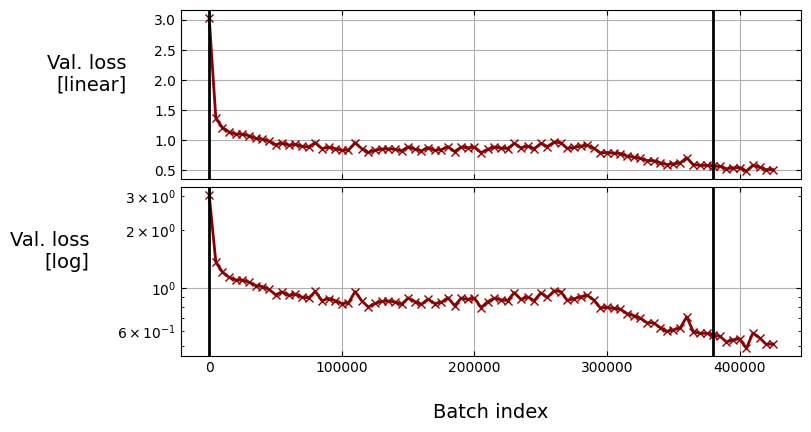

In [25]:
##====================================##
##   Visualise loss during training   ##
##====================================##

if len(loss_record.val_loss) == 0 :
    logger.warning("Not plotting training loss curve because no data found")
else :
    logger.info("Plotting training loss curve")
    
    fig = plt.figure(figsize=(8, 4.5))
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    ax1 = fig.add_subplot(2, 1, 1)
    ax1.tick_params(axis="both", which="both", top=True, right=True, direction="in")
    ax1.grid()

    ax1.xaxis.set_ticklabels([])
    ax1.set_ylabel("Val. loss\n[linear]", ha="right", fontsize=14, labelpad=20, rotation=0)

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.tick_params(axis="both", which="both", top=True, right=True, direction="in")
    ax2.grid()

    ax2.set_ylabel("Val. loss\n[log]", ha="right", fontsize=14, labelpad=20, rotation=0)
    ax2.set_xlabel("Batch index", va="top", fontsize=14, labelpad=20)

    x, y, yerr = loss_record.batch_indices, loss_record.val_loss, loss_record.val_loss_std
    x, y, yerr = np.array(x), np.array(y), np.array(yerr)
    ax1.plot(x, y, "x-", lw=2, c="darkred")
    ax2.plot(x, y, "x-", lw=2, c="darkred")
    if len(yerr) :
        ax1.fill_between(x, y-yerr, y+yerr, lw=0, fc="darkred", alpha=0.3)
        ax2.fill_between(x, y-yerr, y+yerr, lw=0, fc="darkred", alpha=0.3)
    ax2.set_yscale("log")
    
    epoch_transition = -0.5
    while epoch_transition < layer_activation_record.batch_indices[-1] :
        ax1.axvline(epoch_transition, ls="-", lw=2, c="k")
        ax2.axvline(epoch_transition, ls="-", lw=2, c="k")
        epoch_transition += layer_activation_record.num_steps
    
    plt.show(fig)
    

In [26]:
##=========================================================================##
##   Quick function for plotting the data stored in our custom callbacks   ##
##=========================================================================##

def plot_tracks(record, y_label, num_col=3) :
    layer_names = [layer_name for layer_name, layer_mean in record.layer_means.items() if len(layer_mean) > 0]
    layer_names = sorted(layer_names)
    
    num_row = math.ceil(len(layer_names) / num_col)

    fig = plt.figure(figsize=(4*num_col, 4*num_row))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for layer_idx, layer_name in enumerate(layer_names) :

        ax  = fig.add_subplot(num_row, num_col, 1+layer_idx)
        ax.tick_params(which="both", axis="both", direction="in", left=True, top=True, labelsize=8)
        ax.set_title(layer_name, fontsize=6)

        x  = np.array(record.batch_indices)
        y  = np.array(record.layer_means[layer_name])
        ey = np.array(record.layer_stds [layer_name])

        if not len(y) : continue

        ax.plot(x, y, "-", lw=3, c='k')
        ax.fill_between(x, y-ey, y+ey, fc="darkblue", alpha=0.2, lw=0)
        
        if layer_idx == 0 :
            ax.text(0, 1.2, f"{y_label} vs batch index", weight="bold", ha="left", 
                    va="bottom", fontsize=16, transform=ax.transAxes)

    plt.show(fig)
    

   INFO  Plotting layer weights


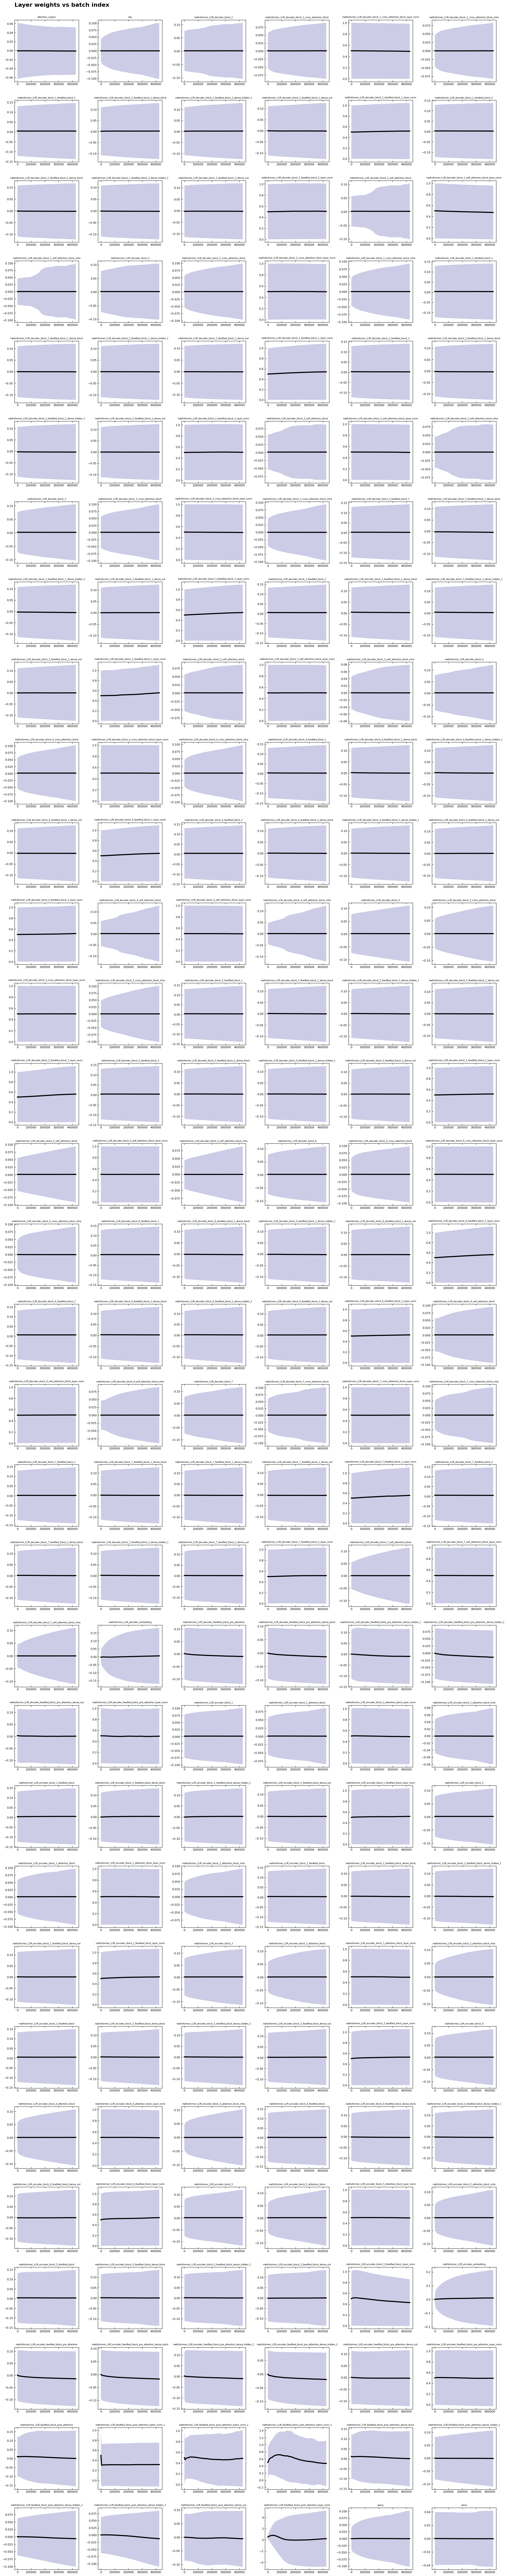

In [27]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if len(layer_weights_record.batch_indices) == 0 :
    logger.warning("Not plotting layer weights because no data found")
else :
    logger.info("Plotting layer weights")
    plot_tracks(layer_weights_record, "Layer weights", num_col=6)
    